 LOW/MID/HIGH
[29, 0, 44]
accuracy_score: 0.4166666666666667
confusion_matrix: 
[[23  6]
 [36  7]]
precision_score: [0.38983051 0.53846154]
72days trade
posestion: -17500.0

                  Volume     Open     High      Low    Close      Rate  class
Datetime                                                                     
2020-11-04 22:00   38048  135.762  135.976  135.084  135.897  0.000994    NaN
[0.]


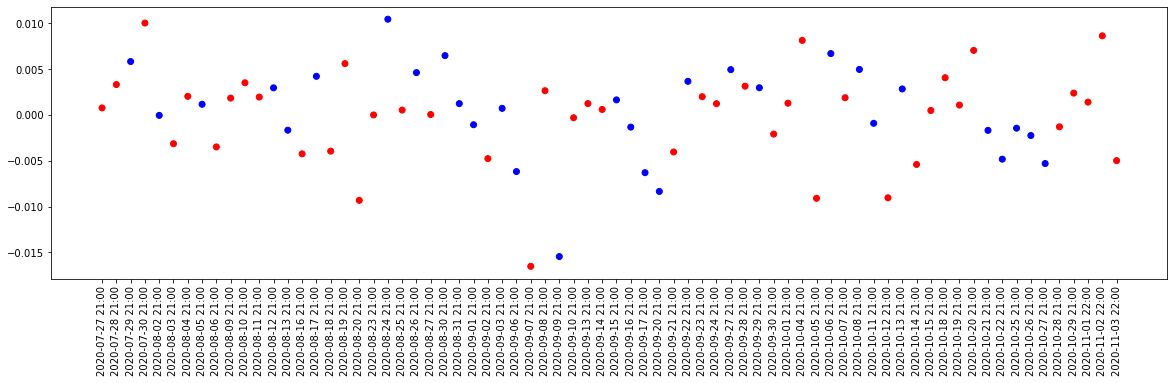

In [1]:
# -*- coding: utf-8 -*-
from oandapyV20 import API
from oandapyV20.exceptions import V20Error
from oandapyV20.endpoints.pricing import PricingStream
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.instruments as instruments

import json
import datetime
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta

import time

%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
import pickle

#自分のアカウント、トークンをセット
accountID = "101-009-16415310-001"
access_token = '860c2d2dbbcd01b6d95939b6af6b5981-8664724ce0870220c55161d704137df6'

api = API(access_token=access_token, environment="practice")
        
# Oandaからcandleデータを取得する。
def getCandleDataFromOanda(instrument, api, date_from, date_to, granularity):
    params = {
        "from": date_from.isoformat(),
        "to": date_to.isoformat(),
        "granularity": granularity,
    }
    r = instruments.InstrumentsCandles(instrument=instrument, params=params)
    return api.request(r)

def oandaJsonToPythonList(JSONRes):
    
    data = []
    for res in JSONRes['candles']:
        temp = [(datetime.datetime.fromisoformat(res['time'][:19])).strftime('%Y-%m-%d %H:%M')]#indexとなる時間を追加
        
        #temp.extend([datetime.datetime.fromisoformat(res['time'][:19]).hour]) #時間を追加
                
        #temp.extend([datetime.datetime.fromisoformat(res['time'][:19]).day])  #日を追加
        
        temp.extend([res['volume'],
            res['mid']['o'],
            res['mid']['h'],
            res['mid']['l'],
            res['mid']['c'],
            ])
        data.append(temp)
    return data




def get_now_data(period_Days, money='USD_JPY', foot = 'D', back_month = 0):
    all_data = []
    
    NY = datetime.timedelta(hours=-14)
    back = datetime.timedelta(days=-back_month*30)
    
    date_from = datetime.datetime.now()+datetime.timedelta(days=-period_Days) + NY + back
    date_to = datetime.datetime.now() + NY + datetime.timedelta(seconds=-1) + back

    ret = getCandleDataFromOanda(money, api, date_from, date_to, foot)
    month_data = oandaJsonToPythonList(ret)#取得したデータを格納

    all_data.extend(month_data)#データを追加

    # pandas DataFrameへ変換
    df = pd.DataFrame(all_data)

    df.columns = ['Datetime','Volume', 'Open', 'High', 'Low', 'Close']
    df['Open'] = df['Open'].astype('double')
    df['Close'] = df['Close'].astype('double')
    
    df['Rate']=(df['Close']-df['Open'])/df['Open']
    
    df = df.set_index('Datetime')
    
    return df

def classify_two(x, c):
        if x<=0:
            c[0]+=1
            return 0
        elif 0<x:
            c[2]+=1
            return 2

def main(filename, days):
    
    df = get_now_data(period_Days=days, money='GBP_JPY', foot = 'D', back_month = 0)
    df.to_csv('now_data.csv', mode = 'w')
    count = [0,0,0]
    df['class'] = (df["Rate"]).apply(lambda x: classify_two(x, count))
    df['class'] = df['class'].shift(-1)
    print(" LOW/MID/HIGH")
    print(count)
    
    last_df = df.tail(1)

    X = df.drop('class', axis=1)
    y = df['class']
    X = X.drop(X.index[len(X)-1])
    y = y.dropna()
    
    clf = pickle.load(open(filename, 'rb'))
    result = clf.predict(X)

    print('accuracy_score: ', end='')
    print(accuracy_score(y, result))
    print('confusion_matrix: ')
    print(confusion_matrix(y, result))
    print('precision_score: ', end='')
    print(precision_score(y, result, average=None))

    possestion = 50000
    pay = 5000
    po_rate = 1.95

    for i in range(len(result)):
        possestion -= pay
        if (result[i]==0):#Low予想のとき
            if (result[i]==y[i]): #予測成功
                possestion += pay*po_rate

        elif(result[i]==2):#High予想の時
            if (result[i]==y[i]): #予測成功
                possestion += pay*po_rate
        else:  #Mid予想の時
            possestion += pay
    print(str(len(result))+"days trade")
    print("posestion: "+ str(possestion))
    
    print('')
    print(last_df)
    print(clf.predict(last_df.drop('class', axis=1)))
    
    
    
    
    plt.figure(figsize=(20,5))
    
    X = X.astype(float)
    
    color = []
    marker = []
    for x in range(0,len(result)):
        if y.values[x] == result[x]:
            color.extend(['blue'])
            
        else:
            color.extend(['red'])

    
    plt.scatter(X.index.values, X["Rate"].values, color=color)
    
    plt.xticks(rotation=90)
    
    
    plt.show()
    

main('LDA_01.sav', 100)